In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# #QUAL GPU VOCÊ QUER USAR?
GPU_GLOBAL = 0


In [2]:
 import os
 os.chdir("drive/My Drive/visao-mestrado")

FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/visao-mestrado'

In [3]:
import tensorflow as tf


2024-01-15 14:04:44.729128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#configure gpu 
!conda install tensorflow-gpu




^C

CondaError: KeyboardInterrupt



In [6]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [7]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Substitua 0 pelo índice da GPU que deseja usar
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Erro ao definir a GPU, geralmente devido a dispositivos já em uso
        print(e)

print(gpus)

[]


In [22]:

# PATH_IMAGENS_N = 'menshift-imagens/dataset/lamina/4_divisao_deixar_apenas_uma_imagem_por_campo_de_lamina_SEM_ERROS/Negativo/*.jpg'
# PATH_IMAGENS = 'menshift-imagens/dataset/lamina/4_divisao_deixar_apenas_uma_imagem_por_campo_de_lamina_SEM_ERROS/Positivo/*.jpg'


PATH_IMAGENS_N = 'dataset/meanshift/predictions/negativo/novo/*jpg*recorte.png'
PATH_IMAGENS = 'dataset/meanshift/predictions/positivo/novo/*recorte.png'


In [23]:
from skimage.io import imread_collection

leshimania = imread_collection(PATH_IMAGENS)
notleshimania = imread_collection(PATH_IMAGENS_N)

In [10]:
!ls menshift-imagens/

ls: cannot access 'menshift-imagens/': No such file or directory


In [24]:
len(notleshimania)

0

In [13]:
from skimage.transform import resize
import numpy as np
# leshimania_resized = [np.array(resize(img,(224, 224))) for img in leshimania]
# notleshimania_resized = [np.array(resize(img,(224, 224))) for img in notleshimania]


In [14]:
# leshimania_resized = np.array(leshimania_resized)
# notleshimania_resized = np.array(notleshimania_resized)

leshimania_resized = np.array(leshimania)
notleshimania_resized = np.array(notleshimania)

In [15]:
EPOCHS = 125
BATCH_SIZE = 8

In [16]:
from matplotlib import pyplot as plt
def funcaoPlot(imagens, title=None):
    fig, ax = plt.subplots(1, len(imagens), figsize=(60, 60))
    for i, folha in enumerate(imagens):
        ax[i].imshow(folha, cmap="gray")
        if title:
            ax[i].set_title(title[i])
        else:
            ax[i].set_title(str(i))

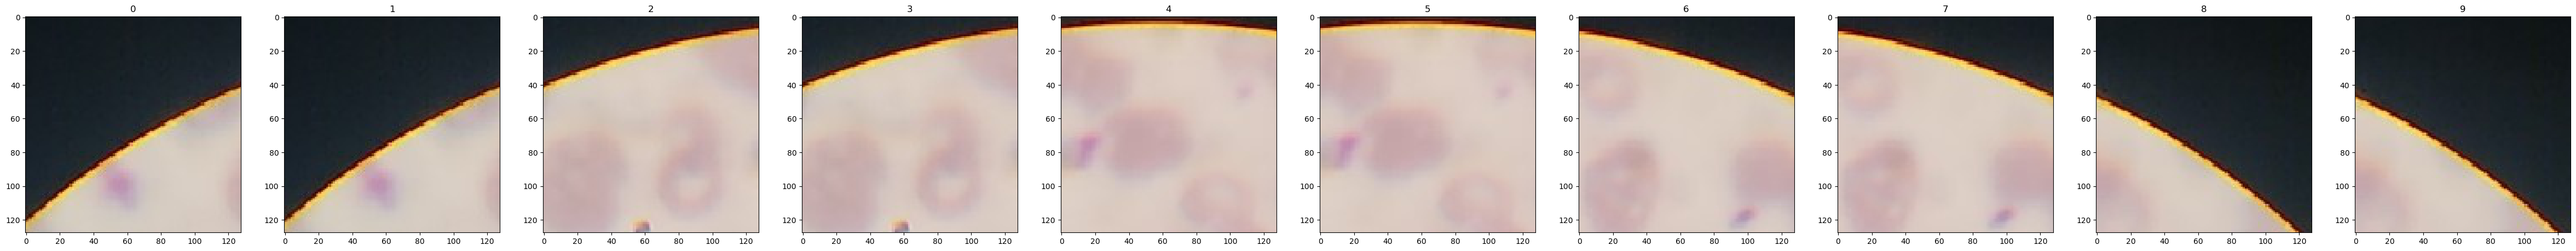

In [17]:
funcaoPlot(leshimania_resized[:10])

In [18]:
leshimania_label = np.ones(len(leshimania_resized))
notleshimania_label = np.zeros(len(notleshimania_resized))

In [20]:
from sklearn.model_selection import train_test_split

X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(leshimania_resized, leshimania_label, test_size=0.7, random_state=40)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(notleshimania_resized, notleshimania_label, test_size=0.7, random_state=40)

X_train = np.concatenate((X_train_true,X_train_false), axis=0)
X_test = np.concatenate((X_test_true,X_test_false), axis=0)
y_train = np.concatenate((y_train_true,y_train_false), axis=0)
y_test = np.concatenate((y_test_true,y_test_false), axis=0)

ValueError: With n_samples=0, test_size=0.7 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=BATCH_SIZE)

In [ ]:
funcaoPlot(X_train[:10])

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras import backend as K

# Função para calcular o F1-score
def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Carregar a arquitetura VGG16 sem os pesos pré-treinados e sem as camadas superiores
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Adicionar novas camadas para classificação
x = base_model.output
x = Flatten()(x)  # Achatar os outputs para um vetor
x = Dense(1024, activation='relu')(x)  # Adicionar uma camada densa
predictions = Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária

# Construir o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Treinar o modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // BATCH_SIZE)

model.save('vgg16_img_grande_125_epocas_batch_8_zero.h5')


# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")

Tranferencia de apredizagem:

In [ ]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam


# Carregar a arquitetura VGG16 sem os pesos pré-treinados e sem as camadas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas da VGG16
for layer in base_model.layers:
    layer.trainable = False

# Adicionar novas camadas para classificação
x = base_model.output
x = Flatten()(x)  # Achatar os outputs para um vetor
x = Dense(1024, activation='relu')(x)  # Adicionar uma camada densa
predictions = Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária


# Adicionar as camadas personalizadas sobre a base da VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Nova camada FC e ReLU
predictions = Dense(1, activation='sigmoid')(x)  # Nova camada de saída para classificação binária

# Montar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                  metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')]
)

# Treinar o modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // BATCH_SIZE)

model.save('vgg16_img_grande_125_epocas_batch_8_tranfer.h5')

# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")

##Fine Tuning

In [ ]:
# Descongelar todas as camadas da VGG16 para fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',     metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])


# Treinar o modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // BATCH_SIZE)

model.save('vgg16_img_grande_125_epocas_batch_8_fine_turning.h5')

# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")

In [ ]:
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Descongelar todas as camadas da VGG16 para fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',     metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])


# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint(filepath='melhor_modelo_fine_tuning.h5', save_best_only=True, monitor='val_loss', mode='min')

# Adicionar os callbacks no método fit
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)

model.save('vgg16_img_grande_125_epocas_batch_8_fine_turning.h5')

# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")